# Title: Customising intertidal exposure calculations TODO: update <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook


## Background
### Intertidal Exposure



*Talk about applications and why it is useful to model exposure*

### Introduction to the Intertidal Exposure calculation method

DEA Intertidal Exposure models the percentage of time that any intertidal pixel of known elevation is exposed from tidal inundation. Exposure is calculated by comparing the pixel elevation back against a high temporal resolution model of tide heights for that location, based on an ensemble tidal modelling approach. Exposure percentage is calculated as the fraction of exposed observations relative to the total number of observations generated in the high temporal resolution tidal model for the 3-year product epoch.

| DEM | High temporal tide model |
|---|---|
| <img src="https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/Carnot_2019_2021_Elevation.png?_xsrf=MnwxOjB8MTA6MTcxNTgzMzg3MHw1Ol94c3JmfDEzMjpNekF4T0RCaE1XWTRZV0ZqTkdJd1pqazBabVJrTVRVek4yWTBNall5WlRrNlptUTVaamt6T0dabE9ETmxaR1EwWmpVMU1USmlZelUwWVRreU56a3labUZpTWpGak16TmxaV05pWVdGaFltSTBZV0ZoT0RjMk1EQTJNRFppWlRRek5nPT18YWIwNmQyZGU0N2UzNzUzODBiODRjZjBkNTI4YmE2MzE4ZmNiMTUwZjYxMjQ5YWViMjRhODM3MWY3YmVmZDNhZQ" width="600" height="300"> | <img src="https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/Carnot_bay_30min_tide_model.png?_xsrf=MnwxOjB8MTA6MTcxNTgzMzg3MHw1Ol94c3JmfDEzMjpNekF4T0RCaE1XWTRZV0ZqTkdJd1pqazBabVJrTVRVek4yWTBNall5WlRrNlptUTVaamt6T0dabE9ETmxaR1EwWmpVMU1USmlZelUwWVRreU56a3labUZpTWpGak16TmxaV05pWVdGaFltSTBZV0ZoT0RjMk1EQTJNRFppWlRRek5nPT18YWIwNmQyZGU0N2UzNzUzODBiODRjZjBkNTI4YmE2MzE4ZmNiMTUwZjYxMjQ5YWViMjRhODM3MWY3YmVmZDNhZQ" width="600" height="300"> |

| Exposure Map | Percentile tide height distribution |
|---|---|
| <img src="https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/Carnot_2019_2021_Exposure.png?_xsrf=MnwxOjB8MTA6MTcxNTgzMzg3MHw1Ol94c3JmfDEzMjpNekF4T0RCaE1XWTRZV0ZqTkdJd1pqazBabVJrTVRVek4yWTBNall5WlRrNlptUTVaamt6T0dabE9ETmxaR1EwWmpVMU1USmlZelUwWVRreU56a3labUZpTWpGak16TmxaV05pWVdGaFltSTBZV0ZoT0RjMk1EQTJNRFppWlRRek5nPT18YWIwNmQyZGU0N2UzNzUzODBiODRjZjBkNTI4YmE2MzE4ZmNiMTUwZjYxMjQ5YWViMjRhODM3MWY3YmVmZDNhZQ" width="600" height="300"> |  <img src="https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/Exposure%20method%20concept%20model.png?_xsrf=MnwxOjB8MTA6MTcxNTgzMzg3MHw1Ol94c3JmfDEzMjpNekF4T0RCaE1XWTRZV0ZqTkdJd1pqazBabVJrTVRVek4yWTBNall5WlRrNlptUTVaamt6T0dabE9ETmxaR1EwWmpVMU1USmlZelUwWVRreU56a3labUZpTWpGak16TmxaV05pWVdGaFltSTBZV0ZoT0RjMk1EQTJNRFppWlRRek5nPT18YWIwNmQyZGU0N2UzNzUzODBiODRjZjBkNTI4YmE2MzE4ZmNiMTUwZjYxMjQ5YWViMjRhODM3MWY3YmVmZDNhZQ" width="600" height="300"> |

### Custom filtering of the Intertidal Exposure calculation
| Custom filtering | Custom filtered Exposure |
| --- | --- |
| ![image](https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/Carnot_exposure_options_tidemodelling2.gif?_xsrf=MnwxOjB8MTA6MTcxNTgzMzg3MHw1Ol94c3JmfDEzMjpNekF4T0RCaE1XWTRZV0ZqTkdJd1pqazBabVJrTVRVek4yWTBNall5WlRrNlptUTVaamt6T0dabE9ETmxaR1EwWmpVMU1USmlZelUwWVRreU56a3labUZpTWpGak16TmxaV05pWVdGaFltSTBZV0ZoT0RjMk1EQTJNRFppWlRRek5nPT18YWIwNmQyZGU0N2UzNzUzODBiODRjZjBkNTI4YmE2MzE4ZmNiMTUwZjYxMjQ5YWViMjRhODM3MWY3YmVmZDNhZQ) | ![image](https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/Carnot_exposure_options2.gif?_xsrf=MnwxOjB8MTA6MTcxNTgzMzg3MHw1Ol94c3JmfDEzMjpNekF4T0RCaE1XWTRZV0ZqTkdJd1pqazBabVJrTVRVek4yWTBNall5WlRrNlptUTVaamt6T0dabE9ETmxaR1EwWmpVMU1USmlZelUwWVRreU56a3labUZpTWpGak16TmxaV05pWVdGaFltSTBZV0ZoT0RjMk1EQTJNRFppWlRRek5nPT18YWIwNmQyZGU0N2UzNzUzODBiODRjZjBkNTI4YmE2MzE4ZmNiMTUwZjYxMjQ5YWViMjRhODM3MWY3YmVmZDNhZQ) |



## Description

This notebook outlines the general methodology required to calculate intertidal exposure and demonstrates how tailored calculations can be used to investigate specific temporal or spatial influences on exposure times in intertidal ecosystems.

In this notebook, users will:
1. Use a conceptual model to understand how the intertidal exposure calculation is derived
2. Through the use of case studies in a given area of interest, calculate:

    - Full exposure characteristics
    - Temporally filtered exposure characteristics (e.g. wet-season exposure)
    - Spatially filtered exposure characteristics (e.g. high or low tide exposure times)
    - Spatiotemporal filtered exposure characteristics (e.g. wet-season high-tide exposure)

***

### Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [2]:
# cd ../..
%cd /home/jovyan/dea_intertidal/dea-intertidal

/home/jovyan/dea_intertidal/dea-intertidal


In [3]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
import datacube
import cmocean
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from IPython import display
from IPython.core.display import Video
from ipywidgets import Output, GridspecLayout

import odc.geo.xr
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from dea_tools.plotting import display_map, xr_animation, rgb

from intertidal.exposure import exposure

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [5]:
dc = datacube.Datacube(app='Customising_Intertidal_Exposure')

### Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:

* `param_name_1`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.
* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.


Friday afternoon:
Adelaide has a huge hightide offset so decided to change locations.

Gulf of Carpentaria is an important waypoint on the East Asian-Australasian flyway for migratory seabirds with a newly assigned Ramsar site eg
https://wetlandinfo.des.qld.gov.au/wetlands/ecology/components/biota/fauna/fauna-taxon/birds/shore-bird/migratory-qld/south-east-gulf-carpentaria.html
https://eaaflyway.net/wp-content/uploads/2020/12/EAAF149_SE-Gulf-Carpentaria-Wernadinga_Final.pdf

This region also hosts significant patches of seagrass, supporting marine mammal and reptile populations in the Gulf eg
https://eatlas.org.au/geonetwork/srv/eng/catalog.search#/metadata/d9a67694-d803-46ca-8f4b-63fc12d51bd1
https://maps.dea.ga.gov.au/#share=s-4VP658YMch1W6EQySU17ALaCtZ4

The high and lowtide offsets are small in the Gulf too so prototype notebook on Leichardt River region on Monday.

In [6]:
# Identify your area of interest as degree lat/lon coordinates as well
# your nominated time period as start and end dates
study_area = "Smithburne_River_Qld"
query_params = dict(y=(-17.05121, -17.10617),
                    x=(140.90808, 140.97289),
                    time=("2016", "2022"))

# 17.05121°S, 140.90808°E
# 17.10617°S, 140.97289°E


# View the area of interest over a generic basemap. Data will be loaded
# inside the red bounding box.
display_map(x=query_params["x"], y=query_params["y"])

## Load Data
Plan: load data over Gladstone Harbour QLD. Use indexed elevation datasets with exposure codes and tide modelling.

In [7]:
# Load DEA Intertidal for the area of interest, and mask out invalid
# nodata values
ds = dc.load(product="ga_s2ls_intertidal_cyear_3", **query_params)
ds = mask_invalid_data(ds)

# Additionally, load the median annual Landsat 8 imagery for the area
# of interest, and mask out invalid nodata values
geomad_ds = dc.load(
    product="ga_ls8c_nbart_gm_cyear_3",
    measurements=["red", "green", "blue"],
    resampling="cubic",
    like=ds,
)
geomad_ds = mask_invalid_data(geomad_ds)

# Add the geomad data layers into the master dataset

ds['red'] = geomad_ds['red']
ds['green'] = geomad_ds['green']
ds['blue'] = geomad_ds['blue']

# Inspect the combined DEA Intertidal and Geomad dataset
ds

<xarray.Dataset> Size: 202MB
Dimensions:                (time: 7, y: 654, x: 734)
Coordinates:
  * time                   (time) datetime64[ns] 56B 2016-07-01T23:59:59.9999...
  * y                      (y) float64 5kB -1.85e+06 -1.85e+06 ... -1.857e+06
  * x                      (x) float64 6kB 9.495e+05 9.495e+05 ... 9.569e+05
    spatial_ref            int32 4B 3577
Data variables: (12/15)
    elevation              (time, y, x) float32 13MB nan nan nan ... nan nan nan
    elevation_uncertainty  (time, y, x) float32 13MB nan nan nan ... nan nan nan
    exposure               (time, y, x) float32 13MB nan nan nan ... nan nan nan
    ta_hat                 (time, y, x) float32 13MB 1.682 1.682 ... 2.019 2.019
    ta_hot                 (time, y, x) float32 13MB 1.434 1.435 ... 1.889 1.889
    ta_lot                 (time, y, x) float32 13MB -1.338 -1.338 ... -1.753
    ...                     ...
    ta_spread              (time, y, x) float32 13MB 87.0 87.0 ... 93.0 93.0
    qa_ndwi_corr           (time, y, x) float32 13MB nan nan nan ... nan nan nan
    qa_ndwi_freq           (time, y, x) float32 13MB 100.0 100.0 ... 0.0 0.0
    red                    (time, y, x) float32 13MB 651.0 643.0 ... 2.019e+03
    green                  (time, y, x) float32 13MB 1.202e+03 ... 1.793e+03
    blue                   (time, y, x) float32 13MB 964.0 957.0 ... 1.338e+03
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Plot all-epoch elevation and exposure
Plan: calculate exposure for all timesteps in the epoch. Briefly interpret results. Segue into case study examples.

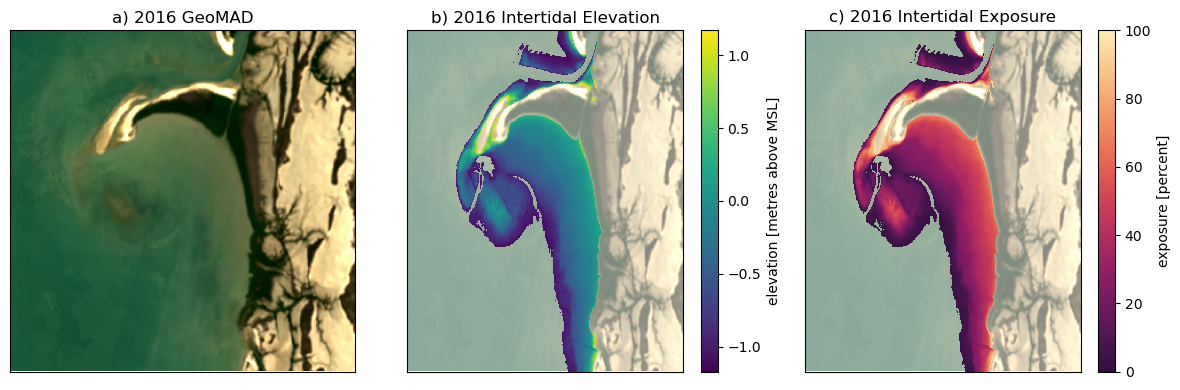

In [8]:
# Plot the intertidal elevation and uncertainty for 2019

# Identify a single timestep to inspect
time = np.datetime_as_string(ds.time.values, unit="Y")[0]

# Setup the figure
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

# Assign the datasets to the figure
rgb(ds.sel(time=time), bands=["red", "green", "blue"], ax=ax[0])

rgb(ds.sel(time=time), bands=["red", "green", "blue"], ax=ax[1], alpha=0.5)
ds.elevation.sel(time=time).plot(ax=ax[1], cmap="viridis")

rgb(ds.sel(time=time), bands=["red", "green", "blue"], ax=ax[2], alpha=0.5)
ds.exposure.sel(time=time).plot(ax=ax[2], cmap=cmocean.cm.matter_r, vmin=0, vmax=100)

# Tidy up the axes
ax[0].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
ax[1].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
ax[2].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)

ax[0].set(xlabel=None, ylabel=None)
ax[1].set(xlabel=None, ylabel=None)
ax[2].set(xlabel=None, ylabel=None)

# Label the figure plots
ax[0].set_title(f"a) {time} GeoMAD")
ax[1].set_title(f"b) {time} Intertidal Elevation")
ax[2].set_title(f"c) {time} Intertidal Exposure")
# fig.suptitle("Figure 2", x=0.04)

plt.tight_layout()


## Temporal filtering of exposure

When considering intertidal exposure, there are many cases where it is advantageous to query exposure times for specific periods in either time or space.

The intertidal exposure algorithm supports temporal filtering of the input time period by any of the following options:
- Monthly (e.g. 'Jan', 'Feb', 'Mar' etc)
- Austral Season (e.g. 'Summer', 'Autumn', 'Winter' or 'Spring')
- Equatorial Season (e.g. 'Dry' or 'Wet')
- Solar (e.g. 'Daylight' or 'Night')

For example, you might be interested in exploring variations in intertidal exposure time to support the characterisation of intertidal seagrass habitat.
To explore exposure times during seagrass germination periods, you might select a 'Wet' season filter.
If you wanted to explore exposure during the peak growing period, you could select the 'Summer' filter.
You can even combine filters.
To quantify the summer solar illumination exposure time, you would combine the 'Summer' and 'Daylight' filters.

These filters are set as follows in the next cell. To experiment with other temporal filters, simply replace the `filters` or `filters_combined` values.

    filters = ['Wet','Summer']
    filters_combined=[('Summer','Daylight')]



In [40]:
# Identify the filters to use to identify datetimes of interest from the high res tidal model
filters = ['Wet','Summer']
filters_combined=[('Summer','Daylight')]

# Use the default settings to calculate a high temporal resolution tide model and
# filter out the nominated datetimes to calculate exposure. Default settings
# include a tide model frequency of 30 minutes and FES2014 tide modelling
exposure_filters, tide_cq_dict = exposure(
    dem=ds.elevation.sel(time=time),
    start_date=str(np.datetime64(time) - np.timedelta64(1,'Y')),
    end_date=str(np.datetime64(time) + np.timedelta64(1,'Y')),
    modelled_freq = '1h',
    # tide_model="ensemble",
    # tide_model_dir=tide_model_dir,
    filters=filters,
    filters_combined=filters_combined,
)

In [57]:
# Add each filtered dataset as a variable layer in the master dataset 'ds'
for x in list(exposure_filters.keys()):
    ds[f'exposure_{str(x)}_{time}']=exposure_filters[str(x)].squeeze(dim='time')
# View the master dataset with new variables added   
ds

<xarray.Dataset> Size: 378MB
Dimensions:                        (time: 7, y: 654, x: 734)
Coordinates:
  * time                           (time) datetime64[ns] 56B 2016-07-01T23:59...
  * y                              (y) float64 5kB -1.85e+06 ... -1.857e+06
  * x                              (x) float64 6kB 9.495e+05 ... 9.569e+05
    spatial_ref                    int32 4B 3577
Data variables: (12/25)
    elevation                      (time, y, x) float32 13MB nan nan ... nan nan
    elevation_uncertainty          (time, y, x) float32 13MB nan nan ... nan nan
    exposure                       (time, y, x) float32 13MB nan nan ... nan nan
    ta_hat                         (time, y, x) float32 13MB 1.682 ... 2.019
    ta_hot                         (time, y, x) float32 13MB 1.434 ... 1.889
    ta_lot                         (time, y, x) float32 13MB -1.338 ... -1.753
    ...                             ...
    exposure_Hightide              (time, y, x) float64 27MB nan nan ... nan nan
    exposure_Lowtide               (time, y, x) float64 27MB nan nan ... nan nan
    exposure_Wet_2016              (y, x) float64 4MB nan nan nan ... nan nan
    exposure_Summer_2016           (y, x) float64 4MB nan nan nan ... nan nan
    exposure_Daylight_2016         (y, x) float64 4MB nan nan nan ... nan nan
    exposure_Summer_Daylight_2016  (y, x) float64 4MB nan nan nan ... nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

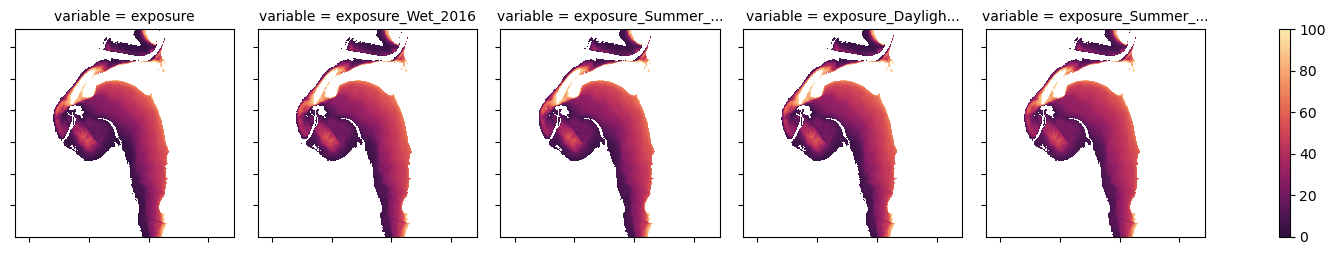

In [59]:
# View the filtered outputs

fig = ds[[
          'exposure',
          'exposure_Wet_2016',
          'exposure_Summer_2016',
          'exposure_Daylight_2016',
          'exposure_Summer_Daylight_2016'
          ]].sel(time=time).to_array().plot(col='variable', col_wrap=5, cmap=cmocean.cm.matter_r, vmin=0,vmax=100)

for ax in fig.axs.flat:
    ax.label_outer()
    ax.set_xticklabels(labels="")
    ax.set_yticklabels(labels="")
    ax.set_xlabel("")
    ax.set_ylabel("")

/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


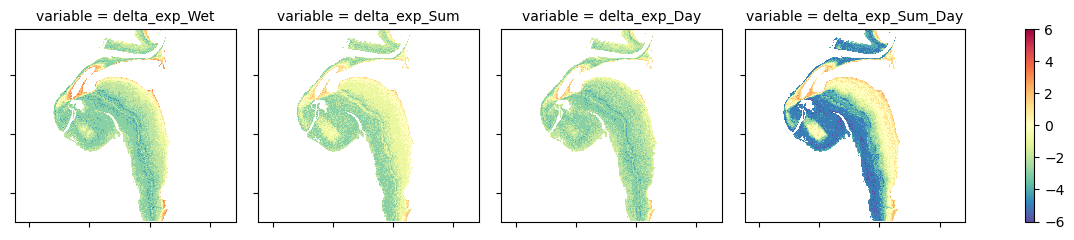

In [60]:
# Calculate the difference between the filtered and unfiltered exposure datasets to confirm that changes were detected

# Calculate the differences relative to the unfiltered exposure dataset
del_exp_Wet =((ds['exposure'].sel(time=time))-(ds['exposure_Wet_2016'])).astype('int').where(ds['exposure'].sel(time=time).notnull())
del_exp_Sum =((ds['exposure'].sel(time=time))-(ds['exposure_Summer_2016'])).astype('int').where(ds['exposure'].sel(time=time).notnull())
del_exp_Day =((ds['exposure'].sel(time=time))-(ds['exposure_Daylight_2016'])).astype('int').where(ds['exposure'].sel(time=time).notnull())
del_exp_Sum_Day =((ds['exposure'].sel(time=time))-(ds['exposure_Summer_Daylight_2016'])).astype('int').where(ds['exposure'].sel(time=time).notnull())

# Combine layers for simplified plotting
delta = del_exp_Wet.to_dataset(name='delta_exp_Wet')
delta['delta_exp_Sum']=del_exp_Sum
delta['delta_exp_Day']=del_exp_Day
delta['delta_exp_Sum_Day']=del_exp_Sum_Day

# Plot the differences relative to the unfiltered exposure dataset
fig=delta[[
    'delta_exp_Wet',
    'delta_exp_Sum',
    'delta_exp_Day',
    'delta_exp_Sum_Day'
            ]].to_array().plot(col='variable', col_wrap=4, cmap='Spectral_r')

# Format the plots
for ax in fig.axs.flat:
    ax.label_outer()
    ax.set_xticklabels(labels="")
    ax.set_yticklabels(labels="")
    ax.set_xlabel("")
    ax.set_ylabel("")

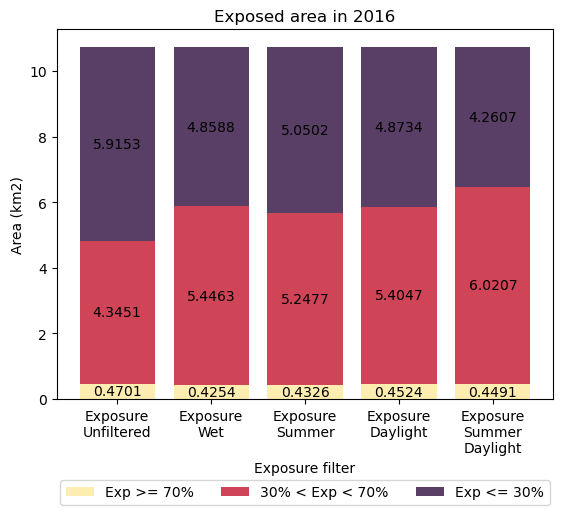

In [12]:
# Quantify exposed areas by categorising 3 broad groupings of exposure values and
# calculating the pixel contributions to each group

# Establish some variables to capture the outputs
exp70_100 = []
exp30_70 = []
exp0_30 = []
labels = []

# Separate the exposure datasets into categories and count the pixels per category
for x in ds.var():
    if 'exp' in x:
        # Prepare the labels for the various exposure datasets        
        if x == 'exposure':
            labels.append(f'Exposure\nUnfiltered')
        if 'exposure_' in x:
            y=x.split('ure_')[-1]
            if '_' in y:
                z=y.split('_')
                labels.append(f'Exposure\n{z[0]}\n{z[-1]}')
            else:
                labels.append(f'Exposure\n{y}')
        # Count the number of pixels exposed between 0 and 100 % of filtered time
        a=ds[str(x)].sel(time=time).count(dim=("x","y")).values

        # Count the number of pixels exposed between 0 and 70 % of filtered time
        b=ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) < 70).count(dim=("x","y")).values

        # Count the number of pixels exposed between 0 and 30 % of filtered time
        c = ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) <= 30).count(dim=("x","y")).values

        # Calculate the pixel count contributions to each class
        exp70_100.append(a[0]-b[0])  
        exp30_70.append(b[0]-c[0])
        exp0_30.append(c[0])

# Prepare the summary data to plot
# Translate 10m2 pixel counts to area as km2
exp_counts = {"Exp >= 70%": (np.array(exp70_100))*0.0001,
              "30% < Exp < 70%": (np.array(exp30_70))*0.0001,
              "Exp <= 30%": np.array(exp0_30)*0.0001}
# Set the y-axis minimum for this stacked bar chart
bottom = np.zeros(5)
# Set the bar width
width = 0.8
# Set the colour scheme
cmap = cmocean.cm.matter_r
# Prepare the figure
fig, ax = plt.subplots()

# Plot the summary datasets on a stacked bar chart.
for var, counts in exp_counts.items():
    
    # Set the colour and transparency for each bar
    if var == list(exp_counts.keys())[0]:
        color=cmap(1.0)
        alpha=1
    if var == list(exp_counts.keys())[1]:
        color=cmap(0.5)
        alpha=1
    if var == list(exp_counts.keys())[2]:
        color=cmap(0)
        alpha=0.8
    # Add the bar to the plot
    p = ax.bar(labels, counts, width, label=var, bottom=bottom,color=color, alpha=alpha)
    # Prepare to stack the next bar
    bottom += counts
    # Label each bar with its contribution to the total area
    ax.bar_label(p, label_type='center')

# Prepare the legend
ax.legend(loc="upper center",
             ncol=3,
             bbox_to_anchor=(0.5, -0.2),
             frameon=True)

# Prepare the labels
ax.set_ylabel("Area (km2)")
ax.set_xlabel("Exposure filter")

# Set the figure subtitle
ax.set_title(f"Exposed area in {time}")

plt.show()

## Spatial filtering of exposure

Scenario: The 2024 QLD DES/DCCEEW Wetland Management Strategy identified goals and future directions for wetland management in Queensland.
These environments are critical to the success of shorebirds, including many migratory species and a wide range of seabirds.
The wetland management strategy identified two objectives relating to the mapping of shorebird habitat in Queensland:
1) Map and make available the location and shorebird use of high tide roost site information
2) Map and make available the location and shorebird use of shorebird feeding areas.

In this example, users will calculate intertidal exposure during average hightide periods to inform shorebird high tide roost site mapping.
Following this, the exercise will be repeated for average lowtide periods to inform calculations of foraging time and occupation space in low tide environments which are critical feeding environments for shore and sea birds.




The intertidal exposure algorithm supports spatial filtering of the input time period by any of the following options:
- Spring tides (e.g. 'Spring_high' or 'Spring_low')
- Neap tides (e.g. 'Neap_high' or 'Neap_low')
- Average high/low tide (e.g. 'Hightide' or 'Lowtide')

In [13]:
# Identify the filters to use to identify datetimes of interest from the high res tidal model
filters = ['Hightide','Lowtide']
filters_combined=None

# Use the default settings to calculate a high temporal resolution tide model and
# filter out the nominated datetimes to calculate exposure. Default settings
# include a tide model frequency of 30 minutes and FES2014 tide modelling
exposure_filters, tide_cq_dict = exposure(
    dem=ds.elevation,
    start_date=query_params['time'][0],
    end_date=query_params['time'][1],
    modelled_freq = '1h',
    filters=filters,
    filters_combined=filters_combined,
)
# Add each filtered dataset as a variable layer in the master dataset 'ds'
for x in list(exposure_filters.keys()):
    ds['exposure_'+str(x)]=exposure_filters[str(x)]
# View the master dataset with new variables added   
ds

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [02:20<00:00, 28.04s/it]


Returning low resolution tide array
-----
Calculating Hightide timerange
-----
Calculating Lowtide timerange
-----
Calculating Hightide exposure
-----
Calculating Lowtide exposure


<xarray.Dataset> Size: 363MB
Dimensions:                   (time: 7, y: 654, x: 734)
Coordinates:
  * time                      (time) datetime64[ns] 56B 2016-07-01T23:59:59.9...
  * y                         (y) float64 5kB -1.85e+06 -1.85e+06 ... -1.857e+06
  * x                         (x) float64 6kB 9.495e+05 9.495e+05 ... 9.569e+05
    spatial_ref               int32 4B 3577
Data variables: (12/21)
    elevation                 (time, y, x) float32 13MB nan nan nan ... nan nan
    elevation_uncertainty     (time, y, x) float32 13MB nan nan nan ... nan nan
    exposure                  (time, y, x) float32 13MB nan nan nan ... nan nan
    ta_hat                    (time, y, x) float32 13MB 1.682 1.682 ... 2.019
    ta_hot                    (time, y, x) float32 13MB 1.434 1.435 ... 1.889
    ta_lot                    (time, y, x) float32 13MB -1.338 -1.338 ... -1.753
    ...                        ...
    exposure_Wet              (time, y, x) float64 27MB nan nan nan ... nan nan
    exposure_Summer           (time, y, x) float64 27MB nan nan nan ... nan nan
    exposure_Daylight         (time, y, x) float64 27MB nan nan nan ... nan nan
    exposure_Summer_Daylight  (time, y, x) float64 27MB nan nan nan ... nan nan
    exposure_Hightide         (time, y, x) float64 27MB nan nan nan ... nan nan
    exposure_Lowtide          (time, y, x) float64 27MB nan nan nan ... nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

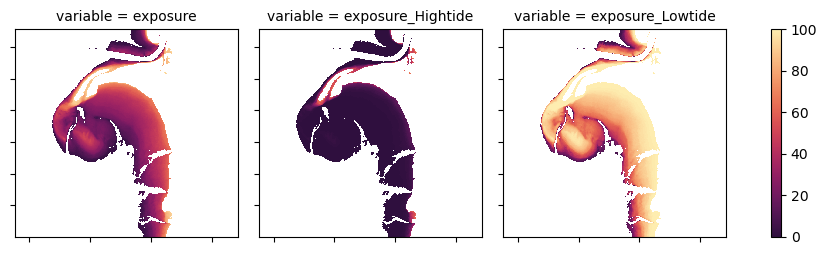

In [14]:
# View the filtered outputs

fig = ds[[
          'exposure',
          'exposure_Hightide',
          'exposure_Lowtide',
          ]].sel(time='2022').to_array().plot(col='variable', col_wrap=3, cmap=cmocean.cm.matter_r, vmin=0,vmax=100)

for ax in fig.axs.flat:
    ax.label_outer()
    ax.set_xticklabels(labels="")
    ax.set_yticklabels(labels="")
    ax.set_xlabel("")
    ax.set_ylabel("")

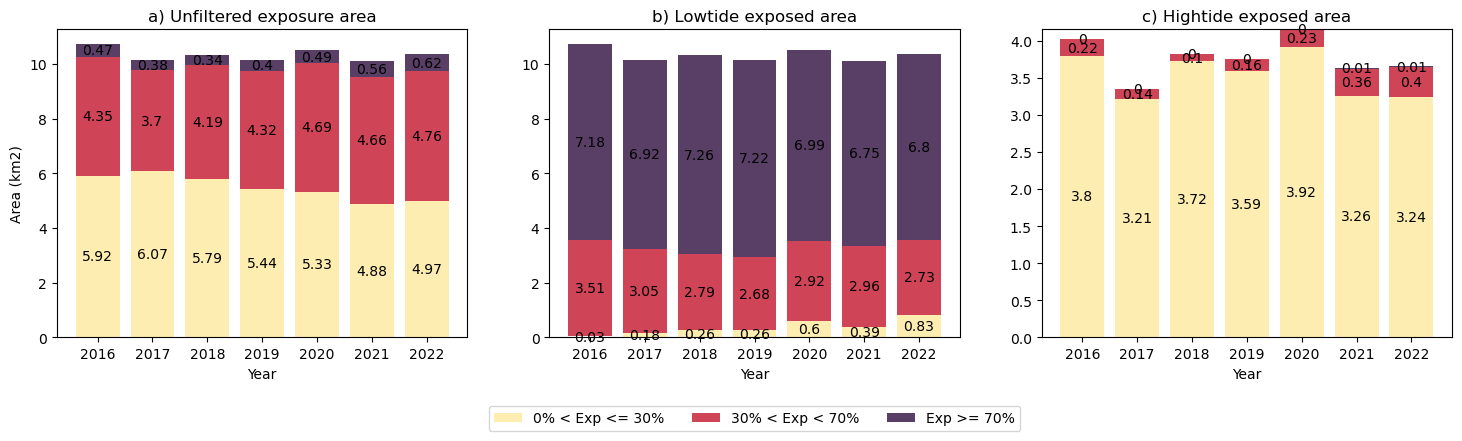

In [15]:
# Prepare exposure data, grouping values based on exposure time
a = ds.exposure_Lowtide.where(ds.exposure_Lowtide >= 70).count(dim=("x", "y")).values
b = ds.exposure_Lowtide.where((ds.exposure_Lowtide < 70)&(ds.exposure_Lowtide > 30)).count(dim=("x", "y")).values
c = ds.exposure_Lowtide.where((ds.exposure_Lowtide <= 30)&(ds.exposure_Lowtide > 0)).count(dim=("x", "y")).values

d = ds.exposure_Hightide.where(ds.exposure_Hightide >=70).count(dim=("x", "y")).values
e = ds.exposure_Hightide.where((ds.exposure_Hightide < 70)&(ds.exposure_Hightide > 30)).count(dim=("x", "y")).values
f = ds.exposure_Hightide.where((ds.exposure_Hightide <= 30)&(ds.exposure_Hightide > 0)).count(dim=("x", "y")).values

g = ds.exposure.where(ds.exposure >= 70).count(dim=("x", "y")).values
h = ds.exposure.where((ds.exposure < 70)&(ds.exposure > 30)).count(dim=("x", "y")).values
i = ds.exposure.where((ds.exposure <= 30)&(ds.exposure > 0)).count(dim=("x", "y")).values

# Prepare the summary data to plot
# Translate 10m2 pixel counts to area as km2

# unfiltered exposure
exp_counts_uf = {"0% < Exp <= 30%": i*0.0001,
                "30% < Exp < 70%": h*0.0001,
                "Exp >= 70%": g*0.0001,
                }

# lowtide exposure
exp_counts_lt = {"0% < Exp <= 30%": c*0.0001,
                 "30% < Exp < 70%": b*0.0001,
                 "Exp >= 70%": a*0.0001
                }

# hightide exposure
exp_counts_ht = {"0% < Exp <= 30%": f*0.0001,
                 "30% < Exp < 70%": e*0.0001,
                 "Exp >= 70%": d*0.0001
                }

# Prepare the date range
dates = np.datetime_as_string(ds.time.values, unit="Y")
# Set the y-axis minimum for this stacked bar chart
bottom = np.zeros(7)
# Set the bar width
width = 0.8
# Set the colour scheme
cmap = cmocean.cm.matter_r
# Prepare the figure
fig, ax = plt.subplots(1,3, figsize=(18,4))

# Plot the summary datasets on a stacked bar chart.
for var, counts in exp_counts_uf.items():
    
    # Set the colour and transparency for each bar
    if var == list(exp_counts_uf.keys())[0]:
        color=cmap(1.0)
        alpha=1
    if var == list(exp_counts_uf.keys())[1]:
        color=cmap(0.5)
        alpha=1
    if var == list(exp_counts_uf.keys())[2]:
        color=cmap(0)
        alpha=0.8
    # Add the bar to the plot
    p = ax[0].bar(dates, counts.round(2), width, label=var, bottom=bottom,color=color, alpha=alpha)
    # Prepare to stack the next bar
    bottom += counts
    # Label each bar with its contribution to the total area
    ax[0].bar_label(p, label_type='center')
    
# Plot the summary datasets on a stacked bar chart.
bottom = np.zeros(7)
for var, counts in exp_counts_lt.items():
    
    # Set the colour and transparency for each bar
    if var == list(exp_counts_lt.keys())[0]:
        color=cmap(1.0)
        alpha=1
    if var == list(exp_counts_lt.keys())[1]:
        color=cmap(0.5)
        alpha=1
    if var == list(exp_counts_lt.keys())[2]:
        color=cmap(0)
        alpha=0.8
    # Add the bar to the plot
    p = ax[1].bar(dates, counts.round(2), width, label=var, bottom=bottom,color=color, alpha=alpha)
    # Prepare to stack the next bar
    bottom += counts
    # Label each bar with its contribution to the total area
    ax[1].bar_label(p, label_type='center')

# Plot the summary datasets on a stacked bar chart.
bottom = np.zeros(7)    
for var, counts in exp_counts_ht.items():

    # Set the colour and transparency for each bar
    if var == list(exp_counts_ht.keys())[0]:
        color=cmap(1.0)
        alpha=1
    if var == list(exp_counts_ht.keys())[1]:
        color=cmap(0.5)
        alpha=1
    if var == list(exp_counts_ht.keys())[2]:
        color=cmap(0)
        alpha=0.8
    # Add the bar to the plot
    p = ax[2].bar(dates, counts.round(2), width, label=var, bottom=bottom,color=color, alpha=alpha)
    # Prepare to stack the next bar
    bottom += counts
    # Label each bar with its contribution to the total area
    ax[2].bar_label(p, label_type='center')
    
# Prepare the legend
ax[1].legend(loc="upper center",
             ncol=3,
             bbox_to_anchor=(0.5, -0.2),
             frameon=True)

# Prepare the labels
# ax[0].set_ylabel("Area (x 100 m2)")
ax[0].set_ylabel("Area (km2)")
ax[0].set_xlabel("Year")
ax[1].set_xlabel("Year")
ax[2].set_xlabel("Year")
# ax[1].set_ylabel("Tide range (%)")
# ax[1].set_xlabel("Year")

# Set the figure subtitles
ax[0].set_title("a) Unfiltered exposure area")
ax[1].set_title("b) Lowtide exposed area")
ax[2].set_title("c) Hightide exposed area")

plt.show()

## Case study 3 - spatiotemporal filtering of exposure

Building upon the seabird example from case study 2, in this example, also filter data for periods of migratory seabird presence in habitat areas of interest.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.8.18


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)